In [11]:
import pickle
import torch
import numpy as np
import collections
import torch.optim as optim 
from utils import get_topwords, plot_fig
from plsv_vae import PlsvVAE
from sklearn.feature_extraction.text import CountVectorizer

In [12]:

with open('data/reuters/preprossed_data.pkl', 'rb') as f: 
    preprossed_data = pickle.load(f)

with open('data/reuters/data_reuters_labels.pkl', 'rb') as f:
    train_label = pickle.load(f)

vectorizer = CountVectorizer(min_df=9)
train_vec = vectorizer.fit_transform(preprossed_data).toarray()
vocab = vectorizer.vocabulary_
nonzeros_indexes = np.where(train_vec.any(1))[0]
train_vec_non_zeros = [train_vec[i] for i in nonzeros_indexes]


train_vec = np.array(train_vec_non_zeros)
print(len(train_vec))
print(len(train_label))
print(len(vocab))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_train_w = torch.from_numpy(np.array(train_vec)).float()
train_label = np.asarray(train_label)

id_vocab = dict(map(reversed, vocab.items()))
num_coordinate = 2
bs = 256
en1_units_x = 100
en2_units_x = 100
num_input = train_vec[0].shape[0]
variance_x = 1
learning_rate = 0.002
beta1 = 0.99
beta2 = 0.999
drop_rate = 0.6
num_topic = 50

7674
7674
3062


## Train

In [13]:
model = PlsvVAE(num_input, en1_units_x, en2_units_x, num_coordinate, num_topic, drop_rate, variance_x, bs, "inverse_quadratic")
model.to(device)
optimizer = optim.Adam(model.parameters(), learning_rate, betas=(beta1, beta2))
epochs = 100
phi_arr = []
beta_arr = []
x_arr = []
recon_arr = []
list_d = []
all_indices = torch.randperm(tensor_train_w.size(0)).split(bs)

for epoch in range(epochs):

    loss_u_epoch = 0.0
    loss_xkl_epoch = 0.0
    loss_betakl_epoch = 0.0
    loss_phikl_epoch = 0.0
    loss_KLD = 0.0
    loss_phi_epoch = 0.0
    recon_ep = 0.0
    loss_epoch = 0.0
    model.train()
    d_temp = []

    for batch_ndx in all_indices:

        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        input_c = None
        recon_v, (loss, loss_u, xkl_loss, kl) = model(input_w, compute_loss=True)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()             # backpror.step()            # update parameters
        loss_epoch += loss.item()
        loss_u_epoch += loss_u.item()
        loss_xkl_epoch += xkl_loss.item() 
        loss_KLD += kl.item() #/ len(tensor_train_w)) 
        recon_ep += recon_v.mean().item() 

    x_arr.append(loss_xkl_epoch)
    recon_arr.append(loss_u_epoch)

    if epoch % 10 == 0:
        print('Epoch {}, loss={}'.format(epoch, loss_epoch))
        print('x_loss={}, recon_loss={}, KLD= {}'.format(loss_xkl_epoch, loss_u_epoch, loss_KLD)) 

Epoch 0, loss=14002.09310913086
x_loss=49.378982067108154, recon_loss=3581769.359375, KLD= 49.378982067108154
Epoch 10, loss=11499.668273925781
x_loss=86.21772265434265, recon_loss=2941473.875, KLD= 86.21772265434265
Epoch 20, loss=11282.548431396484
x_loss=141.66603422164917, recon_loss=2885876.625, KLD= 141.66603422164917
Epoch 30, loss=11098.341278076172
x_loss=197.43582773208618, recon_loss=2838699.5390625, KLD= 197.43582773208618
Epoch 40, loss=10967.162567138672
x_loss=254.67081260681152, recon_loss=2805095.234375, KLD= 254.67081260681152
Epoch 50, loss=10880.365142822266
x_loss=303.1568613052368, recon_loss=2782839.5, KLD= 303.1568613052368
Epoch 60, loss=10813.954864501953
x_loss=345.6233901977539, recon_loss=2765817.6953125, KLD= 345.6233901977539
Epoch 70, loss=10779.943542480469
x_loss=384.10628509521484, recon_loss=2757070.984375, KLD= 384.10628509521484
Epoch 80, loss=10744.285766601562
x_loss=418.23781871795654, recon_loss=2747933.453125, KLD= 418.23781871795654
Epoch 90,

## Test beta and visualization

In [14]:
model.eval()
x_list = []
phi_list = []
beta_list = []
labels_list = []
with torch.no_grad():
    for batch_ndx in all_indices:
        input_w = tensor_train_w[batch_ndx].to(device)
        labels = train_label[batch_ndx]
        labels_list.extend(labels)
        z, recon_v, zx, zx_phi = model(input_w, compute_loss=False)
        zx = zx.view(-1, num_coordinate).data.detach().cpu().numpy()
        x_list.extend(zx)

    x_list = np.array(x_list)

    beta = model.decoder.weight.data.cpu().numpy().T#
    zphi = model.decoder_phi_bn(model.centres).data.cpu().numpy()
    print("---"*10)
    topword_topics = get_topwords(beta, id_vocab)
    for topwords in topword_topics:
        print(topwords)
    print("---"*10)


------------------------------
0: said compani analyst would dome merger dlr co propos market
1: said oil would year trade offici reuter gulf soviet import
2: rev nine year th feb six nd qtr one share
3: mln said stg market bank oil reuter today money port
4: dlr corp acquisit acquir inc asset complet bank merger cash
5: share dlr said mln pct stock reuter inc common outstand
6: offer said tender bid corp compani group inc board cyclop
7: dlr gencorp offer share compani inc taft caesar gener sosnoff
8: dlr loss net share tax sale mln incom stg oper
9: trade said japan would countri reuter minist ec import reagan
10: mln billion dlr profit year reuter extraordinari pre gain cent
11: said share stock split dividend common one set board sharehold
12: mln net qtr nine dlr shr year loss profit inc
13: said reuter would compani share pct mln spokesman last dlr
14: may dividend corp one june six eight ct co march
15: set payout reuter rais co pay fund ct regular note
16: said share would gene

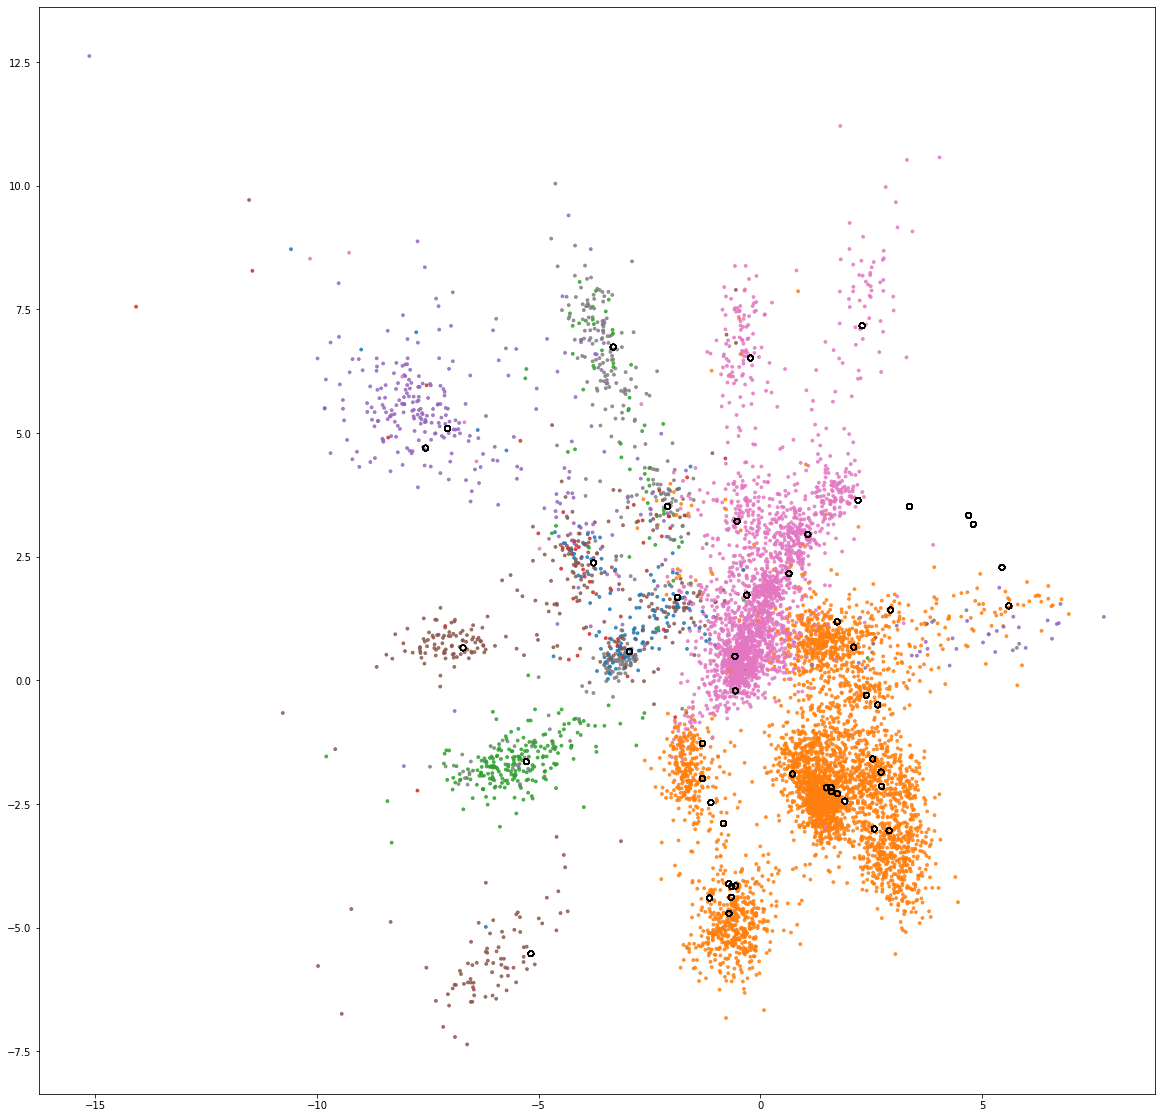

In [15]:
categories = {'ship': 'C0',
             'earn': 'C1',
             'interest': 'C2',
             'grain': 'C3',
             'trade': 'C4',
             'crude': 'C5',
             'acq': 'C6',
             'money-fx': 'C7'}
plot_fig(x_list, labels_list, categories, zphi)